# Data-Centric Project

The goal of this project is to determine whether air quality in Zurich and Beijing has deteriorated since the lifting of the Corona lockdowns. We aim to investigate whether the easing of restrictions, which were imposed during the COVID-19 pandemic, had an impact on the air quality in these cities.

Our specific research question is:

**Has the air quality in major cities worsened since the lifting of the Corona lockdowns?**

There are several reasons for comparing Beijing and Zurich. Firstly, these are two very different cities in terms of their size as well as their geographical location and environment. While Zurich is a comparatively small city in Switzerland, Beijing is a very large city in China, heavily industrialized and known for high air pollution. Therefore, a comparison between these two cities can provide interesting insights into the causes and effects of air pollution. Secondly, both cities have sufficient measurement data, allowing us to track and compare air pollution on a daily basis.

We will retrieve and analyze air quality data from an API to determine whether there has been an increase in pollutants in the air since the relaxation of restrictions. In particular, we will investigate whether the levels of nitrogen dioxide (NO2), particulate matter (PM2.5), carbon monoxide (CO), ozone (O3), and sulfur dioxide (SO2) have changed.

We want to find out from which point in time a possible deterioration in air quality can be observed and what factors may have contributed to it. The results of this study could help decision-makers in cities take appropriate measures to improve air quality and protect the health of people.

In [30]:
# Import Libraries
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

# Data Source

The API from *OpenWeatherMap* allows us to retrieve weather data from various locations around the world. With this API, one can access current and historical weather data and integrate it into their applications. The API offers a variety of weather data, such as temperature, humidity, air pressure, wind speed and direction, as well as precipitation probability and amount. For this project, we have used the *Air Pollution API*, as it contains the necessary data for this project. Through the *Air Pollution API*, one can retrieve air quality data for free starting from February 28, 2020.

Additionally, we have used the *Geocoding API* from OpenWeatherMap to obtain the coordinates of the cities we need for querying the weather data.

In [31]:
# API-Schlüssel und Basis-URL
api_key = "e0f28633a486f839fbb074065bc42f51"
base_url = "https://api.openweathermap.org/geo/1.0/direct"

# Liste von Städten für die wir die Breite und Länge abfragen wollen
staedte = ["Zürich", "Peking"]

# Liste von Dictionaries mit Name, Breite und Länge für jede Stadt
cities = []
for stadt in staedte:
    response = requests.get(f"{base_url}?q={stadt}&limit=1&appid={api_key}")
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]["lat"]
            lon = data[0]["lon"]
            cities.append({"name": stadt, "lat": lat, "lon": lon})
            print(f"Die Breite und Länge von {stadt} sind: {lat}, {lon}")
        else:
            print(f"Keine Ergebnisse für {stadt} gefunden.")
    else:
        print(f"Fehler bei der API-Anfrage für {stadt}.")

Die Breite und Länge von Zürich sind: 47.3744489, 8.5410422
Die Breite und Länge von Peking sind: 39.906217, 116.3912757


The measurement values of the cities are requested from the API and returned in a JSON format. We save the data of each city in .json files, so that we can use them later for analysis without having to query the API again.

In [32]:
# API Endpunkte für die Wetterdaten
url = "http://api.openweathermap.org/data/2.5/air_pollution/history"
start = "1606540800"  # November 28, 2020 in Unix timestamp format
end = "1685138400"  # May 27, 2023 in Unix timestamp format
api_key = "e0f28633a486f839fbb074065bc42f51"

for city in cities:
    # API request für die Wetterdaten
    response = requests.get(
        url,
        params={
            "lat": city["lat"],
            "lon": city["lon"],
            "start": start,
            "end": end,
            "appid": api_key,
        },
    )

    # Kontrolle ob die API-Anfrage erfolgreich war
    if response.status_code == 200:
        with open(f"pollution_data_{city['name']}.json", "w") as f:
            json.dump(response.json(), f)
        print(f"Data saved to file: pollution_data_{city['name']}.json")
    else:
        print(f"Error making API request for {city['name']}: {response.status_code}")

Data saved to file: pollution_data_Zürich.json
Data saved to file: pollution_data_Peking.json


## Data Transformation 

For this step, we decided to define two functions that read the data and filter it directly based on the desired pollutants. To improve clarity, we reduced the number of analyzed pollutants and sorted out a few of the measured substances. The choice was not easy at first, as all these substances can have detrimental effects on humans and the environment.

After researching on the internet, we decided on the following substances:

**CO, NO2, O3, SO2, and PM_2.5**

<details>
  <summary>More about the pollutants</summary>
  
1. **Carbon Monoxide (CO)** is a colorless, odorless, and tasteless gas that forms through the incomplete combustion of carbon. It is harmful to humans and the environment as it displaces hemoglobin in the blood, thereby impairing the body's oxygen supply. It also contributes to the acidification of the environment and can lead to the formation of ground-level ozone.

2. **Nitrogen Dioxide (NO2)** is a colorless and odorless gas that forms at high temperatures in combustion processes. It can impair the respiratory tract and lung function and cause health problems at high concentrations. It also contributes to the formation of ground-level ozone and the greenhouse effect.

3. **Ozone (O3)** is a colorless gas that is an important protective layer against the sun's harmful UV radiation in the higher layers of the atmosphere. However, it can also form in lower layers of the atmosphere through a reaction of nitrogen oxides (NOx) and volatile organic compounds (VOCs). Ground-level ozone can impair respiratory pathways and lung function and is a major component of `smog`.

4. **Sulfur Dioxide (SO2)** is a colorless gas that forms during the combustion of fossil fuels like coal and oil. It can be harmful to both humans and the environment by irritating the respiratory tract, causing damage to plants and soil, and contributing to the acidification of the environment.

5. **Particulate Matter (PM2.5)** are fine particles suspended in the air with a diameter of less than 2.5 micrometers. They are produced by combustion processes and wear and tear from tires and brakes. PM2.5 can penetrate deep into the lungs and cause damage there. It can also contribute to the formation of `smog` and haze, reducing visibility and having negative impacts on the environment.
</details>

The function *load_city_data* reads the data from the json and packages it into a dictionary, which is then passed to the function *clean_data*. This function cleans the data and converts it into a DataFrame. The obtained DataFrame is then appended with the name of the city as a column, and subsequently, the DataFrame is returned.

In [33]:
def load_city_data(city_name):
    """
    Lädt die Luftverschmutzungsdaten einer bestimmten Stadt aus einer JSON-Datei,
    bereinigt die Daten und gibt ein Pandas DataFrame zurück.

    Parameters:
        city_name (str): Name der Stadt, dessen Daten geladen werden sollen

    Returns:
        pandas.DataFrame: Ein DataFrame mit bereinigten Luftverschmutzungsdaten der Stadt
    """
    # JSON-Datei einlesen
    with open(f"pollution_data_{city_name}.json", "r") as f:
        data = json.load(f)  # data ist ein Dictionary

    # Datenbereinigung durchführen
    df = clean_data(data)

    # Eine neue Spalte hinzufügen, um die Stadt zu identifizieren
    df["city"] = city_name

    return df

def clean_data(data):
    """
    Bereinigt die Luftverschmutzungsdaten aus einem Dictionary und gibt ein
    Pandas DataFrame zurück.

    Parameters:
        data (dict): Ein Dictionary mit den Rohdaten der Luftverschmutzungsdaten

    Returns:
        pandas.DataFrame: Ein DataFrame mit bereinigten Luftverschmutzungsdaten
    """
    measurements = {}

    # Schleife über jedes Element im 'list'-Schlüssel des JSON-Daten
    for item in data["list"]:
        # Das Datum der Messung entziehen
        date = item["dt"]
        # Die Messdaten bekommen
        measurement_data = item["components"]
        # Die Messdaten im Dictionary mit dem Datum als Schlüssel speichern
        measurements[date] = measurement_data

    # Das Dictionary in ein Pandas DataFrame konvertieren
    df = pd.DataFrame.from_dict(measurements, orient="index")

    # Den Index in ein Datetime-Objekt konvertieren
    df.index = pd.to_datetime(df.index, unit="s")

    # Nur die Spalten behalten, die wir benötigen
    columns = ["co", "no2", "o3", "so2", "pm2_5"]
    df = df[columns]

    return df

After successfully reading in the measurement values, we store them in a DataFrame.

To ensure the reusability of the code, from this point onward, we work with indexing for the chosen cities `staedte[i]`. This has the advantage that other cities can also be compared. We would like to note here that the project applies to Zurich and Beijing.

In [34]:
df_zurich = load_city_data(staedte[0])
df_peking = load_city_data(staedte[1])

The code below is used to correctly format and name the DateTime index of the DataFrame. First, the index is converted into a DateTime object using *pd.to_datetime* to allow for better handling of the time data later on. Then, a name is assigned to the index using *df.index.name*, so that it can be correctly labeled when presenting the data.

In [35]:
# Liste der DataFrames, auf die die Operationen angewendet werden sollen
dataframes = [df_zurich, df_peking]

# Liste für die erstellten Kopien
new_dataframes = []

for df in dataframes:
    df_copy = df.copy()
    df_copy.rename(columns={"co": "CO", "no2": "NO2", "o3": "O3", "so2": "SO2", "pm2_5": "PM2.5"}, inplace=True)
    df_copy.drop(columns=["city"], inplace=True)
    df_copy.index = pd.to_datetime(df_copy.index)
    df_copy.index.name = "Date"
    new_dataframes.append(df_copy)

df_copy_zh, df_copy_pk = new_dataframes


# Exploratory Analysis
In the next step, we conduct Exploratory Data Analysis (EDA). However, it's important first to understand why one would carry out exploratory data analysis. Here is a brief summary with the key points.

*Why is Exploratory Data Analysis (EDA) conducted?*

Exploratory analysis is an important step in the data analysis process to gain a deeper understanding of the data. It allows identifying patterns and trends in the data, detecting outliers and missing values, visualizing the distribution of the data, and uncovering relationships between variables.

*What is the goal of Exploratory Data Analysis?*

The goal of exploratory analysis is to better understand the data, generate hypotheses, and identify problems that need to be solved in data analysis. It can also help us recognize potential relationships between variables and identify outliers.

*How does Exploratory Data Analysis help us?*

Exploratory analysis can aid in decision-making and identifying patterns and trends in the data. By taking a closer look at the data, we can make decisions based on a well-informed foundation.

[Source](https://towardsdatascience.com/exploratory-data-analysis-in-python-a-step-by-step-process-d0dfa6bf94ee)

For the exploratory analysis, we are interested in key metrics such as the arithmetic mean, standard deviation, as well as the minimum and maximum of the dataset. We achieve this initial analysis with [df.describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html).

Since this can be somewhat cluttered and doesn’t say much on its own, in the next step, the data will be visualized to gain a rough overview.

In [36]:
df_copy_zh.describe()

,CO,NO2,O3,SO2,PM2.5
count,21593.000000,21593.000000,21593.000000,21593.000000,21593.000000
mean,370.697041,21.853861,40.099033,5.798952,14.688455
std,230.247532,19.697325,34.606157,7.138024,16.763757
min,140.190000,0.690000,0.000000,0.460000,0.500000
25%,223.640000,6.770000,5.190000,1.880000,3.790000
50%,283.720000,14.220000,36.840000,3.190000,8.260000
75%,433.920000,33.240000,64.370000,6.560000,18.820000
max,2216.340000,131.610000,175.950000,91.550000,176.110000


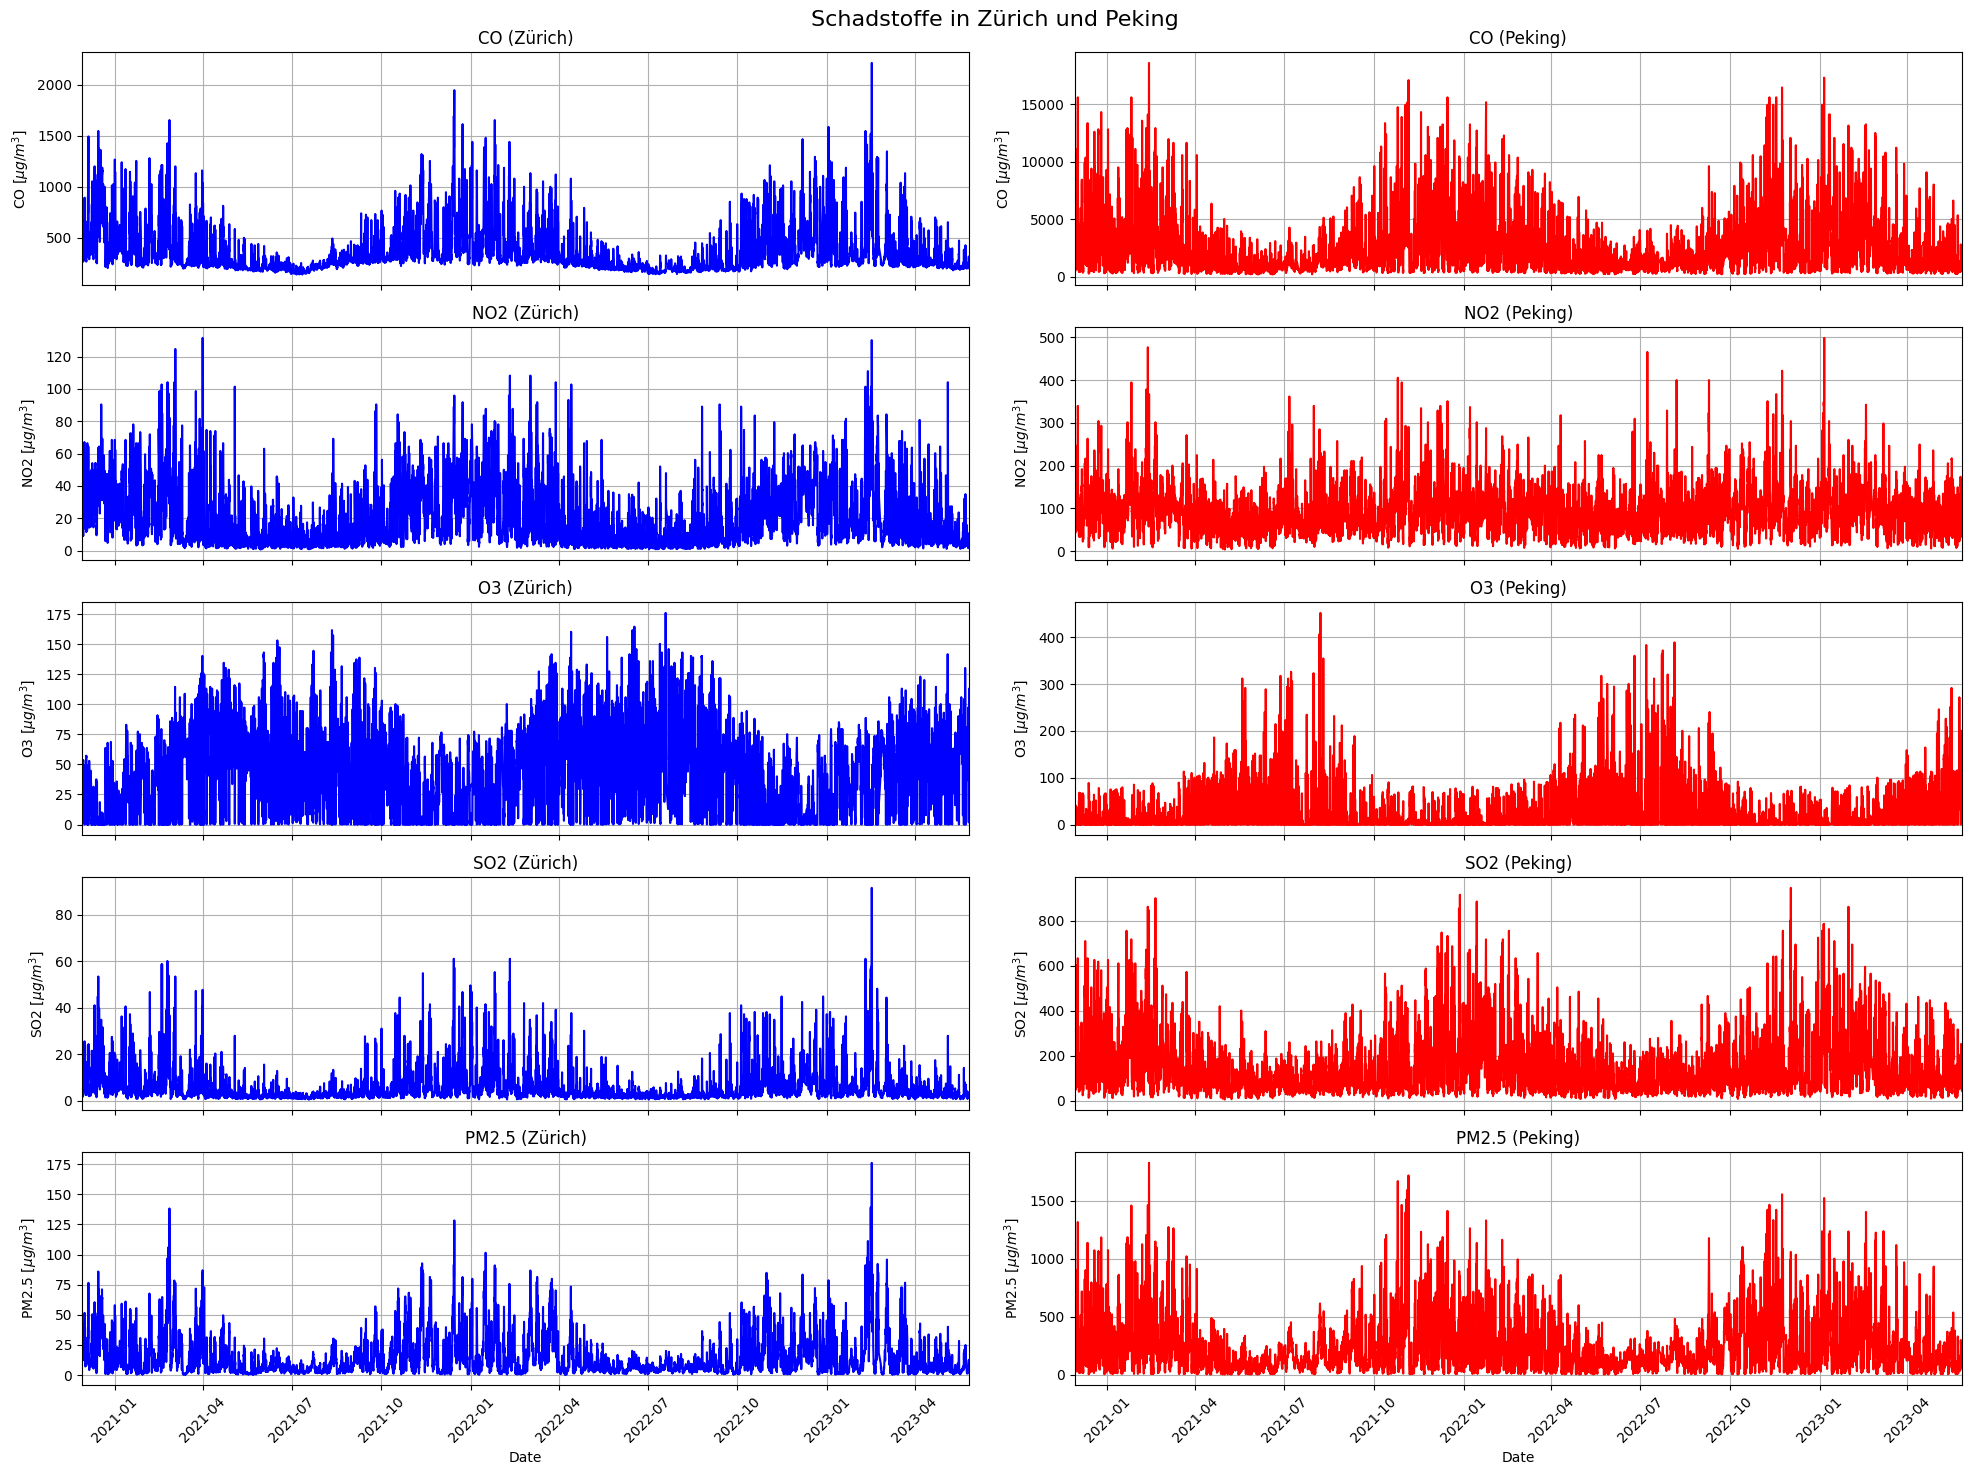

In [37]:
# Erstellung der Grafik mit 5 Subplots der Messwerte
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 15), sharex=True)

# Schleife über alle Spalten in Zürich
for i, col in enumerate(df_copy_zh.columns):
    sns.lineplot(data=df_copy_zh[col], ax=axs[i, 0], linewidth=1.5, color="blue")
    axs[i, 0].set_title(f"{col} ({staedte[0]})")
    axs[i, 0].set_ylabel(f"{col} [$μg/m^3$]")
    axs[i, 0].grid()

    # x-Achsenticks um 45 Grad drehen
    axs[i, 0].tick_params(axis='x', rotation=45)

# Schleife über alle Spalten in Peking
for i, col in enumerate(df_copy_pk.columns):
    sns.lineplot(data=df_copy_pk[col], ax=axs[i, 1], linewidth=1.5, color="red")
    axs[i, 1].set_title(f"{col} ({staedte[1]})")
    axs[i, 1].set_ylabel(f"{col} [$μg/m^3$]")
    axs[i, 1].grid()

    # x-Achsenticks um 45 Grad drehen
    axs[i, 1].tick_params(axis='x', rotation=45)

# Anpassung der Subplot-Abstände
plt.subplots_adjust(wspace=0.25)

# Allgemeine Titel und Beschriftungen
plt.suptitle(f"Schadstoffe in {staedte[0]} und {staedte[1]}", fontsize=16)
plt.tight_layout()
plt.xlim(df_copy_zh.index[0], df_copy_zh.index[-1])

plt.show()


# 1.4 Statistical Visualization

After the initial visualization, we gain a better understanding of how the data is distributed. However, the data is not informative enough. Although highs and lows can be discerned, the scalings of the various measurements are very different. For instance, CO values up to 4400 µg/m³ are considered "good" while particulate matter values are only considered "good" up to 10 µg/m³. This makes interpretation somewhat difficult. For this reason, the measurements are converted into percentage values, with the "very poor" threshold defined as 100%. This allows the data to be presented with the same y-axis scaling.


### Air Quality Index Levels from Air Pollution API (Pollutant concentration in µg/m³)

The table below shows the various air quality indices used by the Air Pollution API to categorize the measurement data into air quality categories. The values are given in micrograms per cubic meter (µg/m³). Source: https://openweathermap.org/api/air-pollution

| Qualitative Name | Index | SO2 [µg/m³]| NO2 [µg/m³]| PM10 [µg/m³]| PM2.5 [µg/m³]| O3 [µg/m³]| CO [µg/m³] |
|------------------|-------|------------|------------|-------------|--------------|-----------|------------|
| Good             | 1     | 0-20       | 0-40       | 0-20        | 0-10         | 0-60      | 0-4400     |
| Fair             | 2     | 20-80      | 40-70      | 20-50       | 10-25        | 60-100    | 4400-9400  |
| Moderate         | 3     | 80-250     | 70-150     | 50-100      | 25-50        | 100-140   | 9400-12400 |
| Poor             | 4     | 250-350    | 150-200    | 100-200     | 50-75        | 140-180   | 12400-15400|
| Very Poor        | 5     | >350       | >200       | >200        | >75          | >180      | >15400     |

The upper threshold values from the above tables are converted into percentage values and rounded to whole numbers. The 'very poor' threshold values are defined as 100%.

In [38]:
# Sehr schlechte Werte für die sechs wichtigsten Schadstoffe als 100% des Index
x_verypoor = [350, 200, 200, 75, 180, 15400]

# Obere gute, mittlere und faire Werte für die sechs wichtigsten Schadstoffe
y_good = [20, 40, 20, 10, 60, 4400]
y_fair = [80, 70, 50, 25, 100, 9400]
y_moderate = [250, 150, 100, 50, 140, 12400]

# Berechnung der Prozentsätze im Index für die Kategorien gut, fair und moderat (Berechnung für schlecht nicht erforderlich)
percent_good = [round(y / x * 100) for x, y in zip(x_verypoor, y_good)]
percent_fair = [round(y / x * 100) for x, y in zip(x_verypoor, y_fair)]
percent_moderate = [round(y / x * 100) for x, y in zip(x_verypoor, y_moderate)]

print("Gute Werte: ", percent_good)
print("Mittlere Werte: ", percent_fair)
print("Moderate Spitzenwerte: ", percent_moderate)

Gute Werte:  [6, 20, 10, 13, 33, 29]
Mittlere Werte:  [23, 35, 25, 33, 56, 61]
Moderate Spitzenwerte:  [71, 75, 50, 67, 78, 81]


### Adjusted Air Quality Index Levels from OpenWeatherMap API with Index in Percentage for Better Comparability (Very Poor Threshold = 100%), Rounded to Whole Numbers

| Qualitative Name | Index | SO2 [%] | NO2 [%] | PM10 [%] | PM2.5 [%] | O3 [%] | CO [%] |
|------------------|-------|---------|---------|----------|-----------|--------|--------|
| Good             | 1     | 0-6     | 0-20    | 0-10     | 0-13      | 0-33   | 0-29   |
| Fair             | 2     | 6-23    | 20-35   | 10-25    | 13-33     | 33-56  | 29-61  |
| Moderate         | 3     | 23-71   | 35-75   | 25-50    | 33-67     | 56-78  | 61-81  |
| Poor             | 4     | 71-100  | 75-100  | 50-100   | 67-100    | 78-100 | 81-100 |
| Very Poor        | 5     | >100    | >100    | >100     | >100      | >100   | >100   |

A new DataFrame is created which initially corresponds to a copy of the original data to avoid altering it.

The measurement values are converted into percentage values, with the respective 'very poor' threshold value defined as 100%.

Through a for-loop, the measurement values for both cities are converted into percentage values and each is stored in a new DataFrame.

In [39]:
# Definition der Schwellenwerte für sehr schlechte Luftqualität für die Top 6 Schadstoffe
very_poor_thresholds = {"CO": 15400, "NO2": 200, "O3": 180, "SO2": 350, "PM2.5": 75}

# Definition der neuen Spaltennamen
new_columns = ["CO_percentage", "NO2_percentage", "O3_percentage", "SO2_percentage", "PM2.5_percentage"]

# Kopie der gefilterten Daten
df_percent_zh = df_copy_zh.copy()
df_percent_pk = df_copy_pk.copy()

# Berechnung der Prozentwerte für Zürich
for column in new_columns:
    # Für Zürich
    pollutant = column.split("_")[0]
    threshold = very_poor_thresholds[pollutant]
    df_percent_zh[column] = (df_percent_zh[pollutant] / threshold) * 100
    # Für Peking
    pollutant = column.split("_")[0]
    threshold = very_poor_thresholds[pollutant]
    df_percent_pk[column] = (df_percent_pk[pollutant] / threshold) * 100

The daily average values of the original measurements and the percentage values are stored in a new DataFrame.

In [40]:
# Tagesmittelerte für Zürich und Peking
df_daily_avg_zh = df_percent_zh.resample("D").mean()
df_daily_avg_pk = df_percent_pk.resample("D").mean()

In [41]:
columns = ["CO_percentage", "NO2_percentage", "O3_percentage", "SO2_percentage", "PM2.5_percentage"]

for col in columns:
    # Zürich
    print(f"Max {col} in {staedte[0]}: {round(df_daily_avg_zh[col].max())}, Min {col}: {round(df_daily_avg_zh[col].min())}")
    # Peking
    print(f"Max {col} in {staedte[1]}: {round(df_daily_avg_pk[col].max())}, Min {col}: {round(df_daily_avg_pk[col].min())}")

Max CO_percentage in Zürich: 10, Min CO_percentage: 1
Max CO_percentage in Peking: 75, Min CO_percentage: 2
Max NO2_percentage in Zürich: 48, Min NO2_percentage: 1
Max NO2_percentage in Peking: 176, Min NO2_percentage: 8
Max O3_percentage in Zürich: 58, Min O3_percentage: 0
Max O3_percentage in Peking: 82, Min O3_percentage: 0
Max SO2_percentage in Zürich: 14, Min SO2_percentage: 0
Max SO2_percentage in Peking: 149, Min SO2_percentage: 5
Max PM2.5_percentage in Zürich: 139, Min PM2.5_percentage: 1
Max PM2.5_percentage in Peking: 1373, Min PM2.5_percentage: 7


Based on the Air Quality Index Levels from OpenWeatherMap API, the daily average values of the percentage values are assigned to corresponding categories. With the added quality index, the data are stored in a new DataFrame.

To categorize the data into quality categories, the previously converted percentage threshold values from the Air Quality Index Levels of OpenWeatherMap API are used to define the bins. The highest threshold used is the highest maximum of the calculated percentage values.

In [42]:
# Definition der Schwellenwerte für die Index-Kategorien
max_percent = 1400
qual_thresholds = {
    "CO" : [0, 29, 61, 81, 100, max_percent],
    "NO2" : [0, 20, 35, 75, 100, max_percent],
    "O3" : [0, 33, 56, 78, 100, max_percent],
    "SO2" : [0, 6, 23, 71, 100, max_percent],
    "PM2.5" : [0, 13, 33, 67, 100, max_percent],
    }

# Definition der neuen Spaltennamen
new_cols = ["CO_qualindex", "NO2_qualindex", "O3_qualindex", "SO2_qualindex", "PM2.5_qualindex"]

# Kopie des Ausgangdataframes
df_avg_indexed_zh = df_daily_avg_zh.copy()
df_avg_indexed_pk = df_daily_avg_pk.copy()

# Berechnung der Index-Kategorien für jeden Schadstoff für beide Städte
for col in new_cols:
    pollutant = col.split("_")[0]
    thresholds = qual_thresholds[pollutant]
    percentages = pollutant + "_percentage"
    df_avg_indexed_zh[col] = pd.cut(df_avg_indexed_zh[percentages], bins=thresholds, labels=[1, 2, 3, 4, 5])
    df_avg_indexed_pk[col] = pd.cut(df_avg_indexed_pk[percentages], bins=thresholds, labels=[1, 2, 3, 4, 5])

In [43]:
# Definition eines neuen "exports" Ordners, falls dieser noch nicht existiert
os.makedirs("exports", exist_ok=True)

# Export der dataframes in CSV in den "exports" Ordner
df_avg_indexed_zh.to_csv("exports/avg_indexed_zh.csv", sep=",", float_format="%.2f", header=True, index=True)
df_avg_indexed_pk.to_csv("exports/avg_indexed_pk.csv", sep=",", float_format="%.2f", header=True, index=True)

In [44]:
def get_qualindex_exceedances(df, qualindex=5):
    """
    Gibt die Daten zurück, an denen der Qualitätsndex für die Schadstoffkonzentrationen für jeden Schadstoff in dem gegebenen DataFrame den mitgegebenen Qualitätsindex haben.
    Standardmäßig ist der Qualitätsindex 5, was "very poor" bedeutet.

    Argumente:
    - df: Ein Pandas DataFrame mit den täglichen Durchschnittskonzentrationen für jeden Schadstoff.

    Rückgabe:
    - Ein Dictionary mit den Namen der Schadstoffe als Keys und einer Liste von Daten als Values, an denen der Qualitätsindex der gegebene ist.
    """
    pollutants = ["SO2", "NO2", "O3", "CO", "PM2.5"]
    exceedances = {}

    for pollutant in pollutants:
        col_name = f"{pollutant}_qualindex"
        if col_name in df.columns:
            dates = list(df[df[col_name] == qualindex].index)
            exceedances[pollutant] = dates

    # Zähle die Anzahl der Überschreitungen für jeden Schadstoff
    for pollutant, dates in exceedances.items():
        num_exceedances = len(dates)
        print(f"{pollutant}: {num_exceedances}")

    # Erstelle das DataFrame
    df_exceedances = pd.DataFrame(
        [(pollutant, len(dates)) for pollutant, dates in exceedances.items()],
        columns=["Pollutant", "Num_Exceedances"],
    )

    return df_exceedances, exceedances

In [45]:
df_exceedances_zh, exceedances_dict_zh = get_qualindex_exceedances(df_avg_indexed_zh, 5)
df_exceedances_pk, exceedances_dict_pk = get_qualindex_exceedances(df_avg_indexed_pk, 5)

SO2: 0
NO2: 0
O3: 0
CO: 0
PM2.5: 5
SO2: 27
NO2: 15
O3: 0
CO: 0
PM2.5: 723


In [46]:
# Export der Daten in JSON
df_exceedances_zh.to_json("exports/Daten_mit_Index5_zh.json")
df_exceedances_pk.to_json("exports/Daten_mit_Index5_pk.json")

In [47]:
# Definition der Spaltennamen welche gelöscht werden sollen
drop_values = ["CO", "NO2", "O3", "SO2", "PM2.5", "CO_qualindex", "NO2_qualindex", "O3_qualindex", "SO2_qualindex", "PM2.5_qualindex"]

# Löschen der Spalten
df_percentages_zh = df_avg_indexed_zh.drop(drop_values, axis=1)
df_percentages_pk = df_avg_indexed_pk.drop(drop_values, axis=1)

In [48]:
# Definition der Qualitätslevels
CO_quality_levels = [29, 61, 81, 100, max_percent]
NO2_quality_levels = [20, 35, 75, 100, max_percent]
O3_quality_levels = [33, 56, 78, 100, max_percent]
SO2_quality_levels = [6, 23, 71, 100, max_percent]
PM2_5_quality_levels = [13, 33, 67, 100, max_percent]

In [49]:
# Defintion der Schadstoffe und Zuordnung der Qualitätslevels
pollutants = [
    ("CO", CO_quality_levels),
    ("NO2", NO2_quality_levels),
    ("O3", O3_quality_levels),
    ("SO2", SO2_quality_levels),
    ("PM2.5", PM2_5_quality_levels)
]

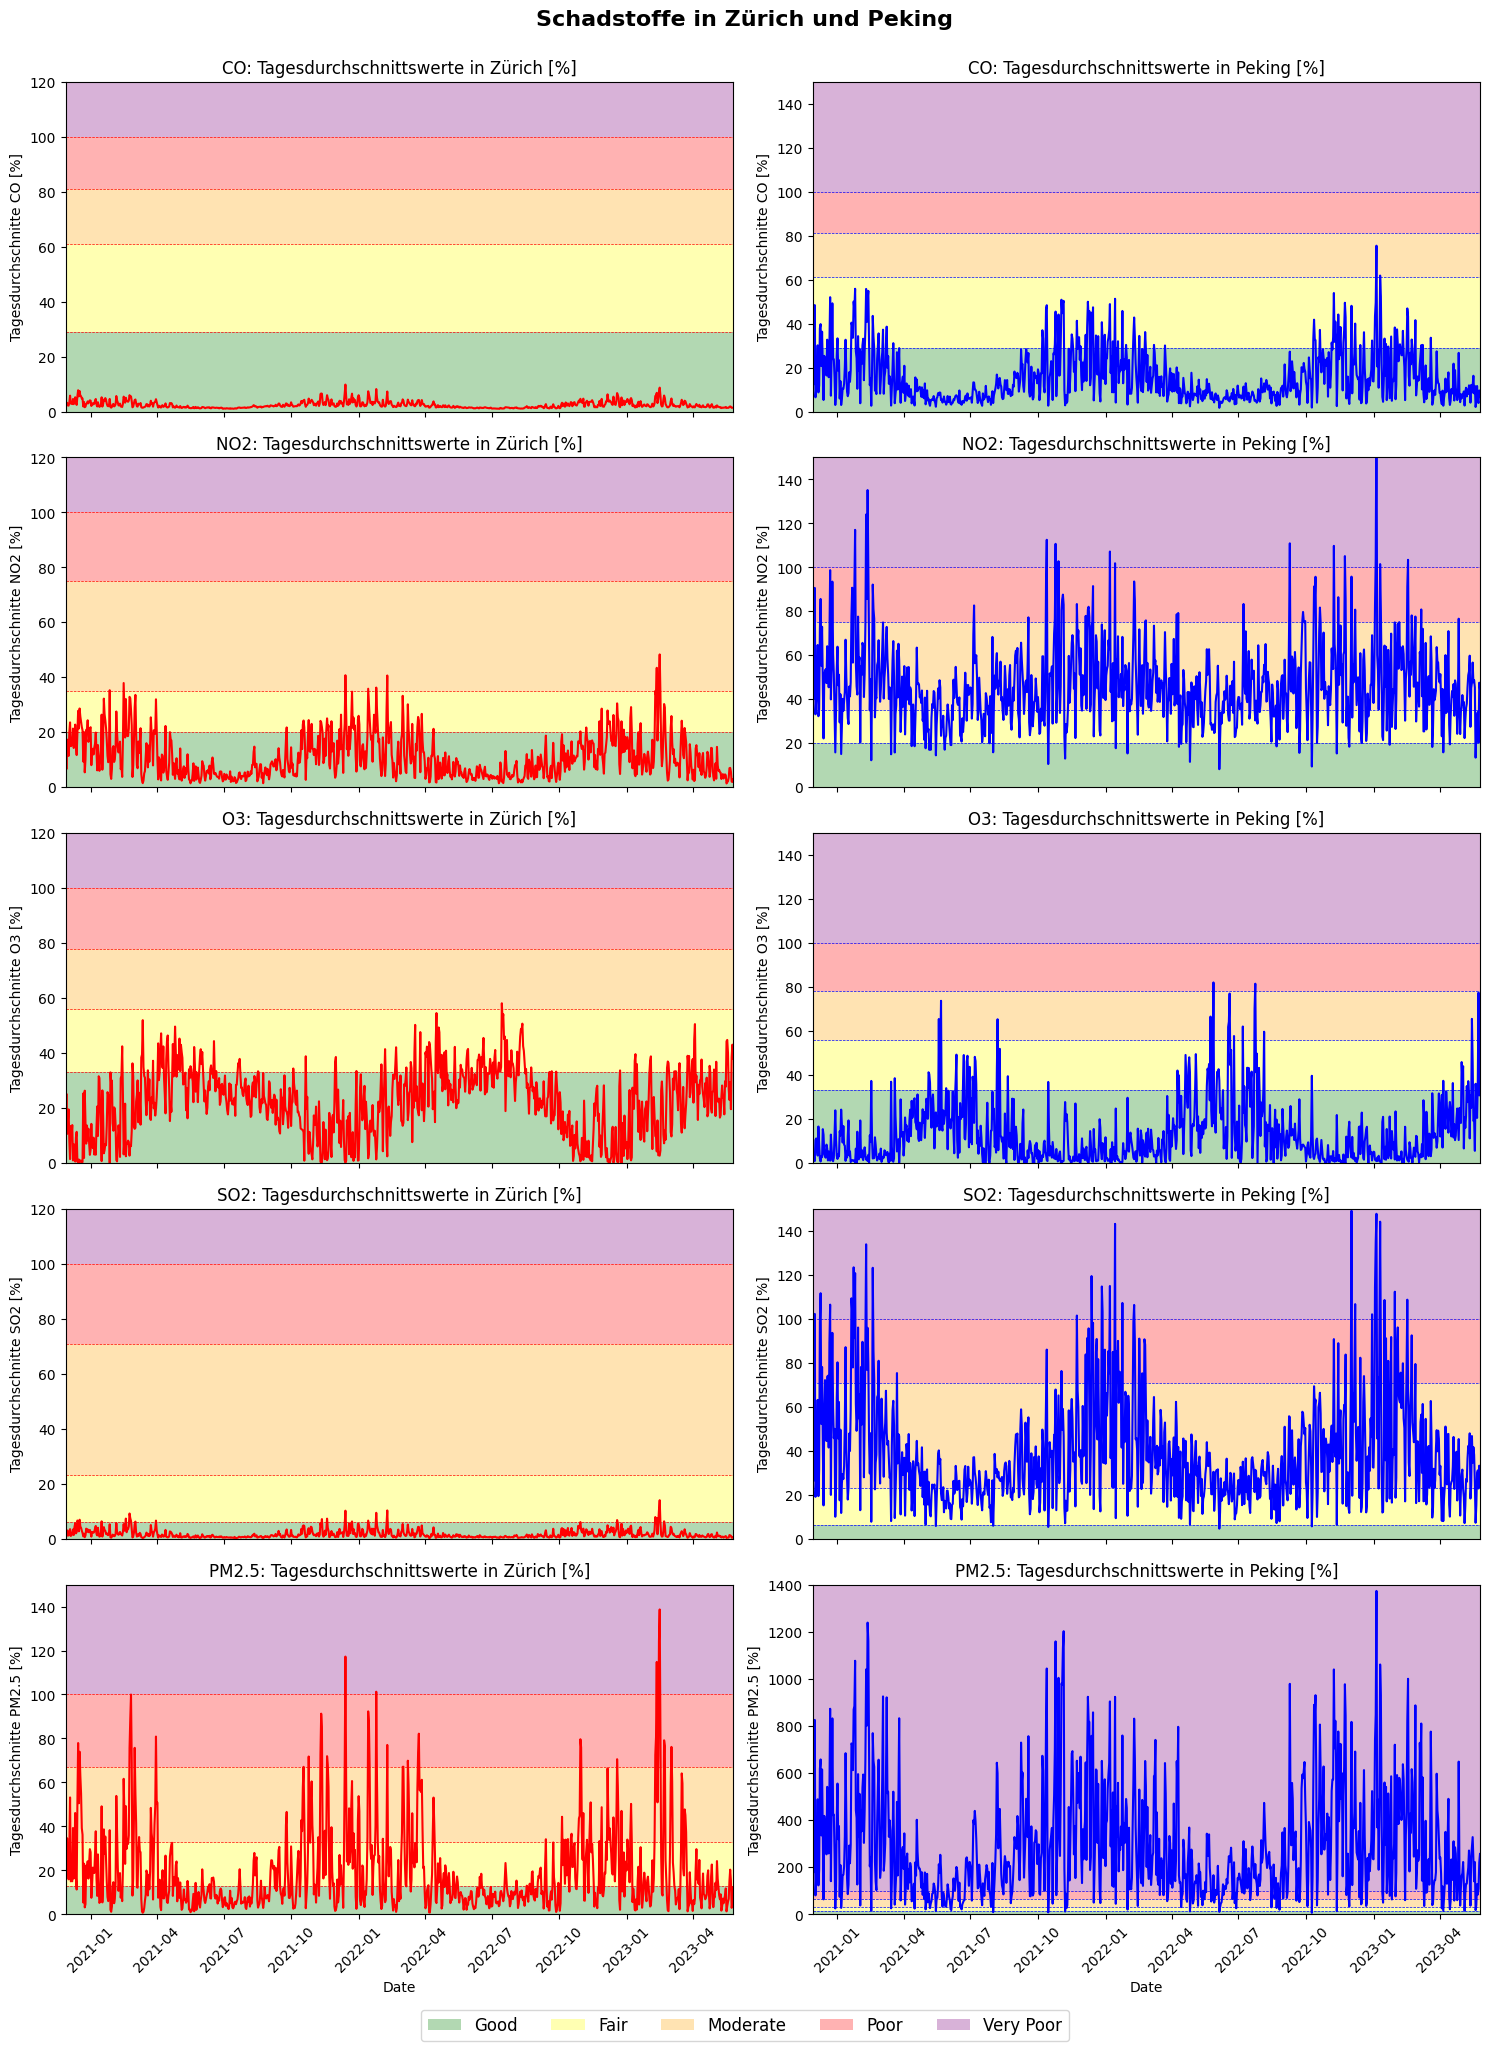

In [50]:
# Grid für die Subplots definieren
fig, axs = plt.subplots(5, 2, figsize=(15, 20), sharex=True)

# Plot für jeden Schadstoff erstellen (Zürich)
for pollutant, (pollutant_name, quality_levels) in enumerate(pollutants):
    ax = axs[pollutant, 0]
    ax.set_title(f"{pollutant_name}: Tagesdurchschnittswerte in {staedte[0]} [%]")
    ax.set_ylabel(f"Tagesdurchschnitte {pollutant_name} [%]")
    if pollutant_name == "PM2.5":
        sns.lineplot(data=df_percentages_zh, x="Date", y=f"{pollutant_name}_percentage", ax=ax, color="red")
        ax.set_ylim(0, 150)
    else:
        sns.lineplot(data=df_percentages_zh, x="Date", y=f"{pollutant_name}_percentage", ax=ax, color="red")
        ax.set_ylim(0, 120)

    # Hinzufügen von Linien für die Qualitätslevels und Einfärben der Bereiche zwischen den Levels
    for qual_level in range(len(quality_levels) - 1):
        ax.axhline(quality_levels[qual_level], color="red", linestyle="--", linewidth=0.5)

    ax.axhspan(ymin=0, ymax=quality_levels[0], facecolor="green", alpha=0.3, label="Good")
    ax.axhspan(ymin=quality_levels[0], ymax=quality_levels[1], facecolor="yellow", alpha=0.3, label="Fair")
    ax.axhspan(ymin=quality_levels[1], ymax=quality_levels[2], facecolor="orange", alpha=0.3, label="Moderate")
    ax.axhspan(ymin=quality_levels[2], ymax=quality_levels[3], facecolor="red", alpha=0.3, label="Poor")
    ax.axhspan(ymin=quality_levels[3], ymax=150, facecolor="purple", alpha=0.3, label="Very Poor")

    # x-Achsenticks um 45 Grad drehen
    axs[i, 0].tick_params(axis='x', rotation=45)

# Plot für jeden Schadstoff erstellen (Peking)
for pollutant, (pollutant_name, quality_levels) in enumerate(pollutants):
    ax = axs[pollutant, 1]
    ax.set_title(f"{pollutant_name}: Tagesdurchschnittswerte in {staedte[1]} [%]")
    ax.set_ylabel(f"Tagesdurchschnitte {pollutant_name} [%]")
    if pollutant_name == "PM2.5":
        sns.lineplot(data=df_percentages_pk, x="Date", y=f"{pollutant_name}_percentage", ax=ax, color="blue")
        ax.set_ylim(0, 1400)
    else:
        sns.lineplot(data=df_percentages_pk, x="Date", y=f"{pollutant_name}_percentage", ax=ax, color="blue")
        ax.set_ylim(0, 150)

    # Hinzufügen von Linien für die Qualitätslevels und Einfärben der Bereiche zwischen den Levels
    for qual_level in range(len(quality_levels) - 1):
        ax.axhline(quality_levels[qual_level], color="blue", linestyle="--", linewidth=0.5)

    ax.axhspan(ymin=0, ymax=quality_levels[0], facecolor="green", alpha=0.3)
    ax.axhspan(ymin=quality_levels[0], ymax=quality_levels[1], facecolor="yellow", alpha=0.3)
    ax.axhspan(ymin=quality_levels[1], ymax=quality_levels[2], facecolor="orange", alpha=0.3)
    ax.axhspan(ymin=quality_levels[2], ymax=quality_levels[3], facecolor="red", alpha=0.3)
    ax.axhspan(ymin=quality_levels[3], ymax=1400, facecolor="purple", alpha=0.3)

    # x-Achsenticks um 45 Grad drehen
    axs[i, 1].tick_params(axis='x', rotation=45)    

# x-Achsenrange für alle Plots gleich setzen
plt.xlim(df_percentages_zh.index[0], df_percentages_zh.index[-1])

# Anpassung der Subplot-Abstände
plt.subplots_adjust(wspace=0.25)

# Allgemeiner Titel für den gesamten Plot und Layout anpassen
plt.suptitle(f"Schadstoffe in {staedte[0]} und {staedte[1]}", fontsize=16, fontweight="bold", y=1)
plt.tight_layout()

# Legende erstellen und außerhalb der Plots positionieren
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.02), loc='lower center', ncol=5, fontsize=12)

# Plot als Bild speichern
plt.savefig("exports/Schadstoffe_ZH_PK_mit_colorcode.png", dpi=300, bbox_inches='tight')

# Plot anzeigen
plt.show()


#### Initial Findings
From the graphs above, we have already gained some initial insights. It is noticeable that pollutant levels depend on the seasons and thus likely on temperatures.

However, we have found that we probably cannot draw sufficient conclusions regarding our research question based on the Air Quality Index Levels. For visualizing the data, it is very helpful, but the resolution of the index is too low to compare the air quality in the cities. In Zurich, most values are in the "good" and "fair" range, except for PM2.5, which is spread across all quality levels. In Beijing, however, PM2.5 values are mostly in the "very poor" and "poor" range. This makes comparing the air quality in the two cities difficult. Whether and how often the measurements exceed or fall below a certain threshold seems to be so strongly dependent on the seasons that it is difficult to compare air quality before and after a single date.

For this reason, we will further analyze the data and present it in a different format.

Certainly, here's the English translation of your text:

### Alternative Analysis of the Data
We have decided to analyze the data using different threshold values in the hope of achieving better resolution of individual days and therefore conducted further research. The threshold values for these pollutants depend on the region and applicable laws and regulations. Through our research, we came across the WHO website and found the threshold values listed below.

**AQG stands for "Air Quality Guideline"** and refers to recommendations and guidelines for air quality. These values are set by various national and international organizations such as the World Health Organization (WHO) and the European Union (EU) and are intended to protect human health and the environment by limiting certain pollutant concentrations in the air. AQG values are often given in relation to specific time intervals, such as for hours, days, or years.

| Pollutant | Averaging Time | Interim Target | AQG Guideline |
| :--- | :--- | :--- | :--- |
| PM2.5  $μg/m^3$ | Year | 35 | 5 |
|  | 24 hours | 75 | 15 |
| PM10 $μg/m^3$ | Year | 70 | 15 |
|  | 24 hours | 150 | 45 |
| O3  $μg/m^3$ | Warm season | 100 | 60 |
|  | 8 hours | 160 | 100 |
| NO2 $μg/m^3$ | Year | 40 | 10 |
|  | 24 hours | 120 | 25 |
| SO2 $μg/m^3$ | 24 hours | 125 | 40 |
| CO $mg/m^3$ | 24 hours | 7 | 4 |

Note: "Interim Target" refers to the long-term target value aimed for, while "AQG Guideline" is the short-term limit that must be met.

[Source](https://apps.who.int/iris/bitstream/handle/10665/345329/9789240034228-eng.pdf?sequence=1&isAllowed=y)

In [51]:
# Definition der Columns, die im neuen Dataframe gelöscht werden sollen
drop_values = [
    "CO_percentage",
    "NO2_percentage",
    "O3_percentage",
    "SO2_percentage",
    "PM2.5_percentage",
    "CO_qualindex",
    "NO2_qualindex",
    "O3_qualindex",
    "SO2_qualindex",
    "PM2.5_qualindex",
]
df_daily_avg_zh = df_avg_indexed_zh.drop(drop_values, axis=1)
df_daily_avg_pk = df_avg_indexed_pk.drop(drop_values, axis=1)

In [52]:
# Definition der AQG Werte in den 24 Studen
aqg_dict = {
    "CO": 4000,  # Umrechnung von mg/m3  in μg/m3
    "NO2": 25,
    "O3": 300,  # Weil der Wert nur für 8 Stunden angegeben wurde
    "SO2": 40,
    "PM2.5": 15,
}


In a graph, we have plotted the daily average values of the original measurements along with the AQG guidelines for 24 hours. The AQG guidelines are shown as dashed lines. Additionally, we have marked the date on which the lockdown was lifted in Switzerland.

We have also included the measurement values from Beijing in the same plot to better compare the differences in levels. We did not find a specific date for when the lockdown was lifted in Beijing, so we have not marked any date for it.

By plotting the air pollution data in Zurich and Beijing, we hope to gain even better insight into the distribution and intensity of various pollutants. For example, we can see if there are specific times of the year when pollutant levels are higher in one city compared to the other, or if there are certain pollutants that show particularly high values. These insights can help us better understand the causes of air pollution.

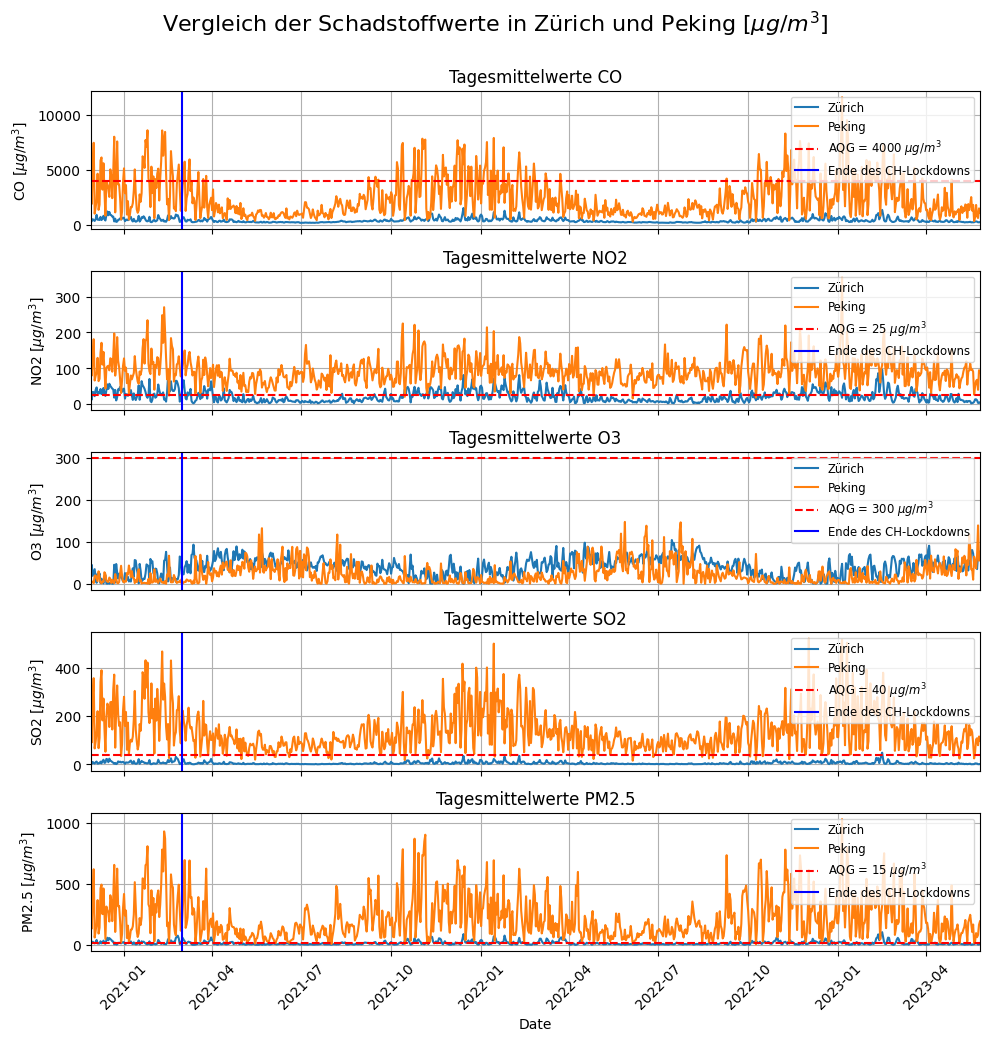

In [53]:
# AQG-Werte für Zürich und Peking
aqg_values = [aqg_dict.get(col.split("_")[0].upper(), None) for col in df_daily_avg_zh.columns]

# Erstellen einer Figur mit ausreichend vielen Reihen und 1 Spalte, die alle die x-Achse teilen
fig, axs = plt.subplots(nrows=len(df_daily_avg_zh.columns), ncols=1, figsize=(10, 10), sharex=True)

# Iteration über die Spalten des gefilterten DataFrames für Zürich
for i, col in enumerate(df_daily_avg_zh.columns):
    # Erstellen eines Diagrams mithilfe von seaborn für Zürich
    sns.lineplot(data=df_daily_avg_zh[col], ax=axs[i], linewidth=1.5, label=staedte[0])
    
    # Erstellen eines weiteren Diagrams mithilfe von seaborn für Peking
    sns.lineplot(data=df_daily_avg_pk[col], ax=axs[i], linewidth=1.5, label=staedte[1])
    
    # Hinzufügen der AQG-Werte als horizontale Linien für Zürich und Peking
    if aqg_values[i] is not None:
        axs[i].axhline(y=aqg_values[i], linestyle="--", color="r", label=f"AQG = {aqg_values[i]} $μg/m^3$")

    # Festlegen des Titels der Subplots
    axs[i].set_title(f"Tagesmittelwerte {col}")
    # Festlegen des Labels für die y-Achse
    axs[i].set_ylabel(f"{col} [$μg/m^3$]")

    # x-Achsenspanne für alle Plots gleich setzen
    axs[i].set_xlim(df_daily_avg_zh.index[0], df_daily_avg_zh.index[-1])

    # Markierung für das Ende des Lockdowns in der Schweiz
    axv_date = datetime.datetime.strptime("2021-03-01", "%Y-%m-%d")
    axs[i].axvline(x=axv_date, color="b", label="Ende des CH-Lockdowns")
    axs[i].legend(loc="upper right", fontsize="small")
    axs[i].grid()

# Visualisierung der Grafik
plt.suptitle(f"Vergleich der Schadstoffwerte in {staedte[0]} und {staedte[1]} [$μg/m^3$]", fontsize=16, y=1)
plt.tight_layout()
plt.xticks(rotation=45)  # Drehen der x-Achsenbeschriftung um 45 Grad
plt.savefig("exports/vergleich_ZH_PK.png", dpi=300, bbox_inches="tight")  # Exportieren des Diagramms als PNG-Datei
plt.show()


It is clear to see that most of the measurement values in Beijing are significantly higher than those in Zurich, which was expected due to the size differences between the cities. Particularly, the particulate matter values in Beijing are much higher than in Zurich.

Even with the AQG thresholds, we have the same issue as with the Air Quality Index Levels from OpenWeatherMap API. Here too, we naturally see a correlation between the seasons and pollutant values, making it difficult to compare air quality before and after a single date. For most pollutants (except O3), there is a downward trend around the time the lockdown was lifted, and this is observed in both cities, from which we can infer that this has no connection with the lifting of the lockdown in Switzerland.



### Visualizing Correlations Between Pollutants

In the previous visualizations, we noticed that pollutant values behave similarly for the most part, with only O3 values seemingly following a different cycle. Therefore, we have decided to calculate and visualize the correlations between pollutants.

A value of 1 indicates that the two variables are positively linearly correlated, meaning that when one variable increases, the other also increases. A value of -1 indicates that the two variables are negatively linearly correlated, meaning that when one variable increases, the other decreases. A value of 0 means that there is no linear correlation between the two variables. The higher the absolute value of the correlation coefficient, the stronger the correlation between the variables; a value of 1 indicates an exact correspondence between them.

You can find more information about correlation coefficients [here](https://www.statology.org/how-to-read-a-correlation-matrix/).

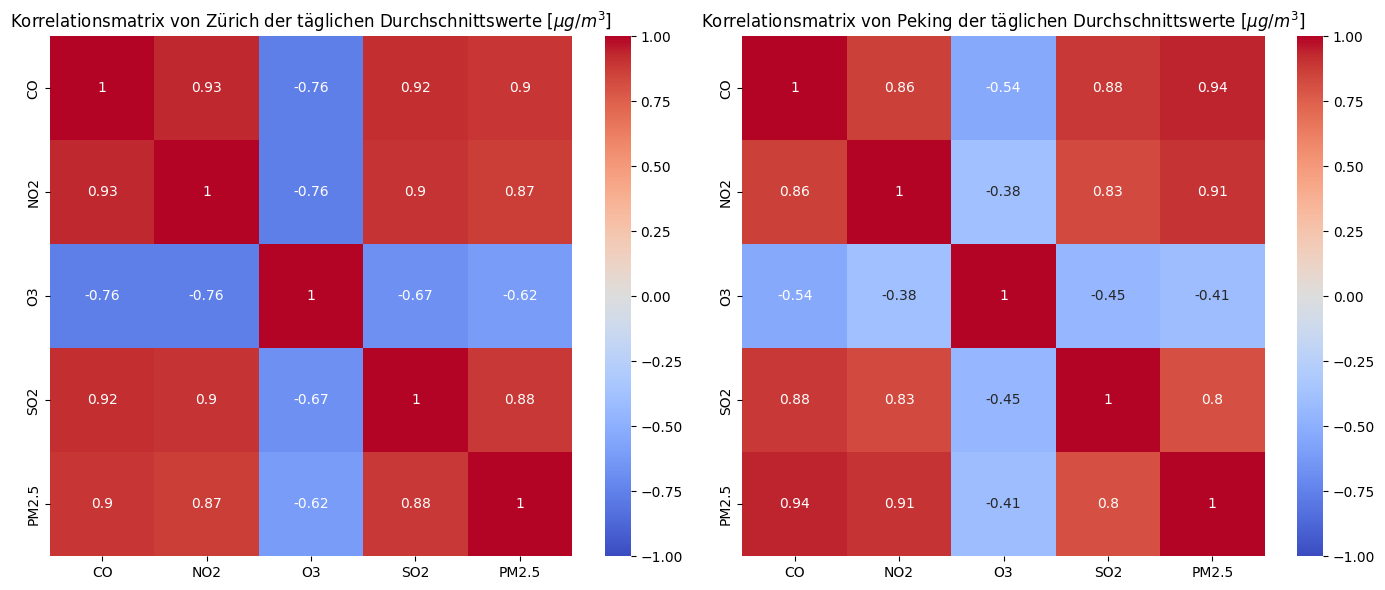

In [54]:
# Berechnung der Korrelationsmatrizen
corr_matrix_zh = df_daily_avg_zh.corr()
corr_matrix_pk = df_daily_avg_pk.corr()

# Grid für die Subplots definieren
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Erstellen des Heatmap-Plots für Zürich
sns.heatmap(corr_matrix_zh, cmap="coolwarm", annot=True, ax=axs[0], vmax=1, vmin=-1)
axs[0].set_title(f"Korrelationsmatrix von {staedte[0]} der täglichen Durchschnittswerte [$μg/m^3$]")

# Erstellen des Heatmap-Plots für Peking
sns.heatmap(corr_matrix_pk, cmap="coolwarm", annot=True, ax=axs[1], vmax=1, vmin=-1)
axs[1].set_title(f"Korrelationsmatrix von {staedte[1]} der täglichen Durchschnittswerte [$μg/m^3$]")

# Abstand zwischen den Subplots definieren
plt.tight_layout()

# Plot anzeigen
plt.show()



### Description of the Correlation Matrix

Based on these correlation matrices, it can be observed that almost all values are strongly *positively linearly* correlated with each other, meaning that when one pollutant increases or decreases, most of the others tend to do the same.

The only exceptions are the O3 values, which are represented in the matrices as a blue cross with low values. This indicates that the O3 values are *negatively linearly* correlated with the others. This confirms what was already observed in the plots of the data over time: when O3 values increase, the other pollutants decrease, and vice versa. In the summer months, O3 values rise while the other pollutants decline, and in the winter months, O3 values decrease while the other pollutants rise.

The negative correlation of the O3 data with the other pollutants can also be visualized through a scatterplot. For this purpose, we created a scatterplot using `seaborn.relplot`, where we plotted the O3 values on the x-axis and the particulate matter (PM2.5) values on the y-axis. We used the SO2 values for color representation and the NO2 values for point size to illustrate the correlation of these values with the others.

With this method, we were able to represent the values of 4 pollutants in one plot and visualize the correlations between the values. This representation may be more intuitively understandable but can become somewhat cluttered with an increasing number of variables.

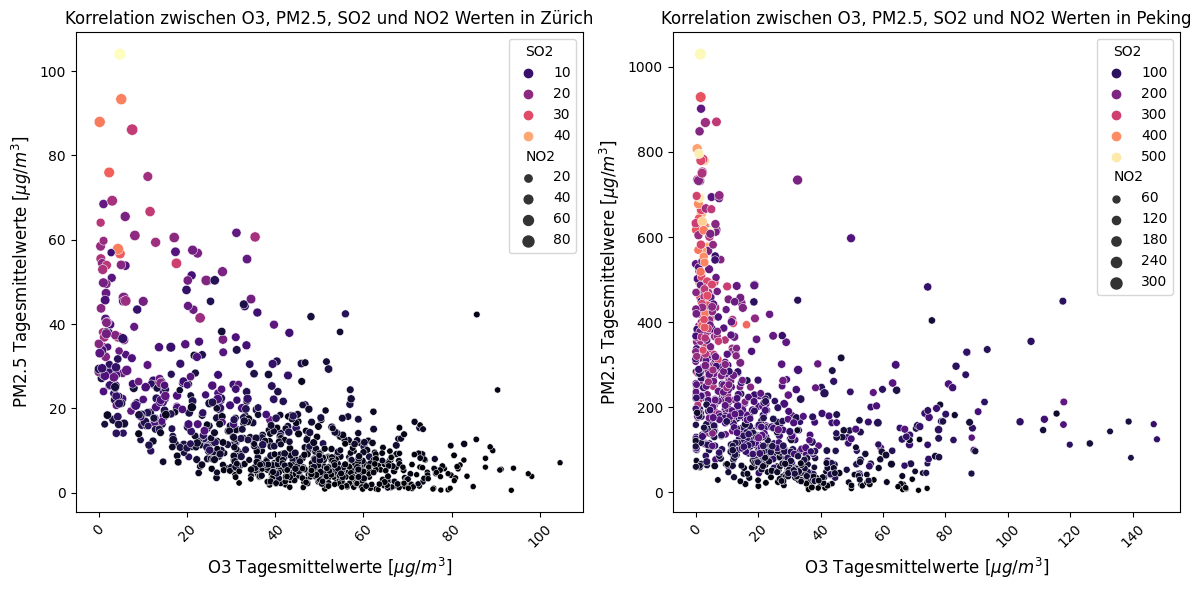

In [55]:
# Erstellung des Plots mit Subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot für Zürich
sns.scatterplot(data=df_daily_avg_zh, x="O3", y="PM2.5", hue="SO2", palette="magma", size="NO2", ax=axs[0])
axs[0].set_title(f"Korrelation zwischen O3, PM2.5, SO2 und NO2 Werten in {staedte[0]}")
axs[0].set_ylabel("PM2.5 Tagesmittelwerte [$μg/m^3$]", fontsize=12)
axs[0].set_xlabel("O3 Tagesmittelwerte [$μg/m^3$]", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# Scatterplot für Peking
sns.scatterplot(data=df_daily_avg_pk, x="O3", y="PM2.5", hue="SO2", palette="magma", size="NO2", ax=axs[1])
axs[1].set_title(f"Korrelation zwischen O3, PM2.5, SO2 und NO2 Werten in {staedte[1]}")
axs[1].set_ylabel("PM2.5 Tagesmittelwere [$μg/m^3$]", fontsize=12)
axs[1].set_xlabel("O3 Tagesmittelwerte [$μg/m^3$]", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)

# Anpassung des Layouts und Anzeige des Plots
plt.tight_layout()
plt.show()

## Revised Research Question

We have realized that our original research question cannot be adequately answered due to the cyclic behavior of pollutants, making it difficult to compare air quality before and after a specific date. Therefore, we have decided to formulate a new research question that can be better addressed with the available data. The new research question is as follows:

**Is air quality in the first four months of 2023 better or worse compared to the same period in the two previous years?**

To answer this new research question, the necessary data will be extracted from the dataframes and stored in new dataframes. These data will then be presented in boxplots to compare the distribution of pollutant values in different years.

In [56]:
# Entfernen der Daten ausserhalb des gwünschten Zeitraums
df_JanApr_zh = df_daily_avg_zh[df_daily_avg_zh.index.month <= 4]
df_JanApr_pk = df_daily_avg_pk[df_daily_avg_pk.index.month <= 4]

In [57]:
# Kopieren der DataFrames
df_JanApr_zh = df_JanApr_zh.copy()
df_JanApr_pk = df_JanApr_pk.copy()

# Hinzufügen der Spalte "Year" mit dem Jahr
df_JanApr_zh['Year'] = df_JanApr_zh.index.year
df_JanApr_pk['Year'] = df_JanApr_pk.index.year

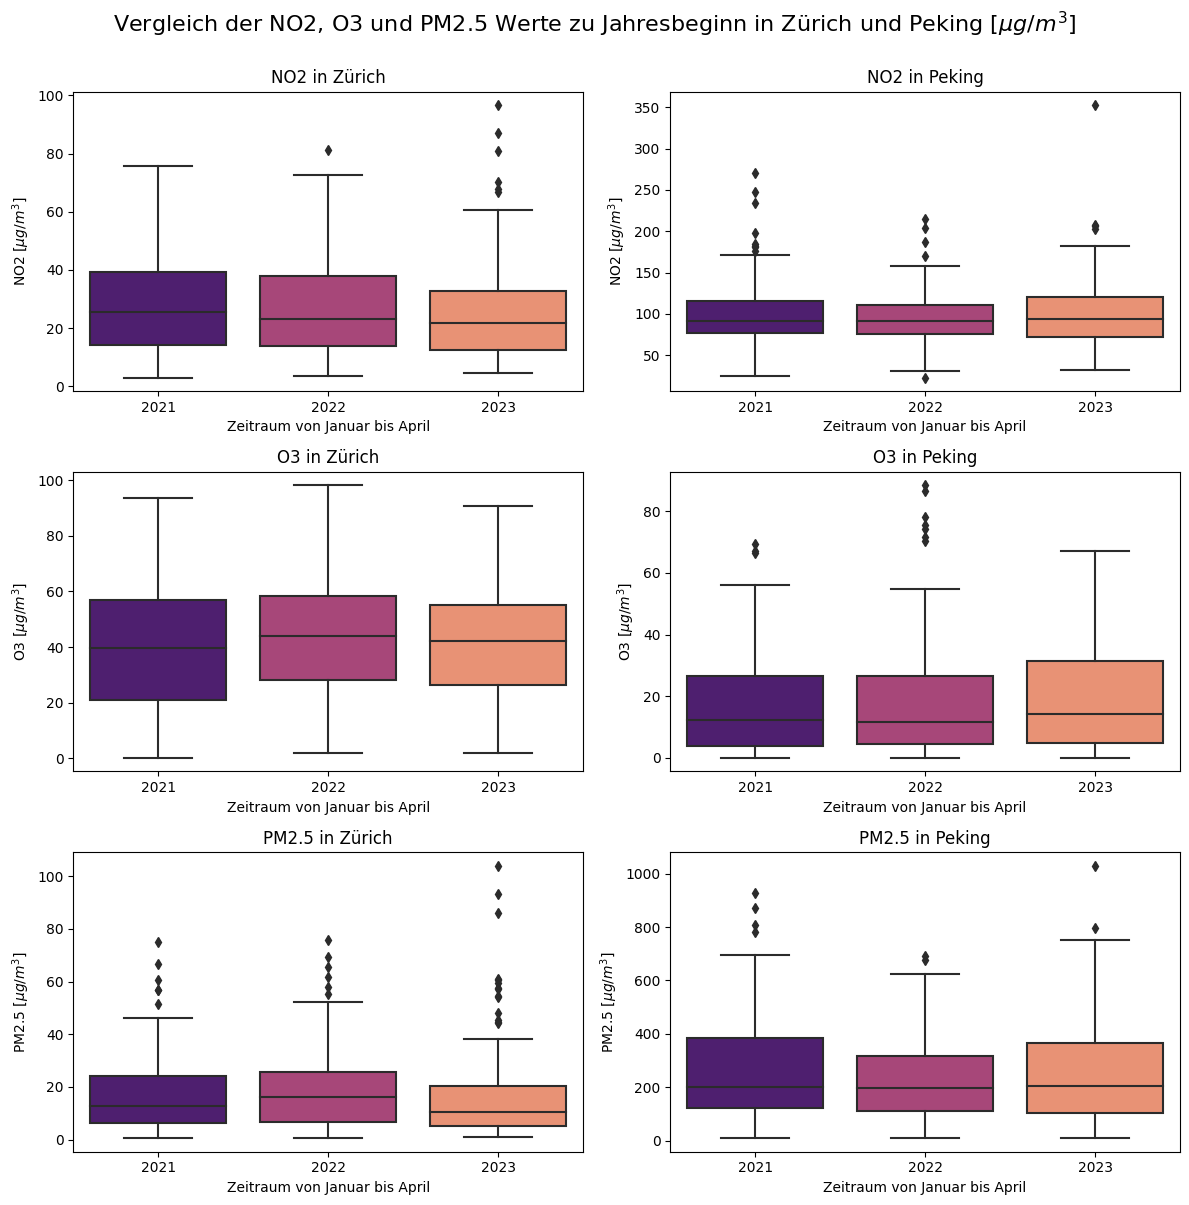

In [58]:
# Zu plottende Schadstoffe
pollutants_to_plot = ["NO2", "O3", "PM2.5"]

# Zu plottende Datensätze
datasets = [df_JanApr_zh, df_JanApr_pk]

# Erstellen des Plots mit Subplots entsprechend der Anzahl Schadstoffe und Datensätze
fig, axs = plt.subplots(nrows=len(pollutants_to_plot), ncols=len(datasets), figsize=(12, 12))

# Erstellen der Boxplots
for i, dataset in enumerate(datasets):
    for j, pollutant in enumerate(pollutants_to_plot):
        sns.boxplot(data=dataset, x="Year", y=pollutant, ax=axs[j, i], palette="magma")

        # x-Achsenbeschriftung
        axs[j, i].set_xlabel("Zeitraum von Januar bis April")

        # y-Achsenbeschriftung
        axs[j, i].set_ylabel(f"{pollutant} [$μg/m^3$]")

        # Titel der Subplots
        if i == 0:
            axs[j, i].set_title(f"{pollutant} in {staedte[0]}")
        else:
            axs[j, i].set_title(f"{pollutant} in {staedte[1]}")

# Visualisierung der Grafik
plt.suptitle(f"Vergleich der NO2, O3 und PM2.5 Werte zu Jahresbeginn in {staedte[0]} und {staedte[1]} [$μg/m^3$]", fontsize=16, y=1)
plt.tight_layout()
plt.savefig("exports/Boxplot_ZH_PK.png", dpi=300, bbox_inches="tight")  # Exportieren des Boxplots als PNG-Datei
plt.show()

With this analysis, we were able to compare air quality in the first four months of the years 2021, 2022, and 2023. Our assumption was that air quality values in 2021 and 2022 were better due to the COVID-19 pandemic compared to 2023 after most restrictions were lifted. However, we could not confirm this hypothesis with our analysis. The data do not show clear trends, and the distributions of pollutant values are very similar across the three years.

## Discussion of Results

Our initial research question was as follows:

**Has air quality worsened in major cities since the lifting of the COVID-19 lockdowns?**

Based on our analyses and visualizations, we were unable to answer the research question definitively. Our approach of categorizing pollutant values into different quality levels proved useful for quantifying the number of days the values fell within each range. Converting the pollutant values into percentage values with the "very poor" threshold set as 100% also proved helpful for data visualization. However, due to the significant fluctuations and cyclic behavior of pollutant values, it is challenging to compare air quality before and after a specific date and draw conclusions about the impact of lockdown lifting. Nevertheless, through correlation matrices and scatterplots, we were able to demonstrate that O3 values show a negative linear correlation with the other pollutants. This means that when O3 values rise, the other pollutants decrease, and vice versa. This behavior is also evident in the time series plots of the data. O3 levels increase during the summer months, and the other pollutants decrease, while in the winter months, O3 levels decrease, and the other pollutants increase.

Based on these findings, we decided to formulate a new research question that could be better answered with the available data. The new question is as follows:

**Is air quality in the first four months of 2023 better or worse compared to the same period in the two previous years?**

We answered this question using boxplots. The data did not show clear trends, and the distributions of pollutant values were very similar. Therefore, we could not confirm that air quality in the first four months of 2023 was worse than in the same months of 2021 and 2022.

### Conclusion

Unfortunately, we were unable to answer our initial research question with the available data. While we were able to answer the second research question, the statements would have been more meaningful with additional data that extended back before the pandemic. However, this data was not freely available through the API we used. Nevertheless, we were able to demonstrate how pollutant values change over time and how their trends correlate. We also highlighted the high levels of fine particulate matter (PM2.5) pollution in Beijing compared to the relatively low levels in Zurich.

### Methods and Skills

Throughout this project, we acquired and deepened various skills. We learned how to access an API and filter data to extract only the relevant information for our analysis. We organized the data into DataFrames using Pandas, a Python library for data analysis and manipulation, and visualized the data in various forms.

We focused particularly on the Seaborn library, which builds upon Matplotlib and provides a wide range of graphics and charts for data visualization. Using Seaborn, we were able to present our data in an illustrative way and identify various trends and patterns in the data.

Furthermore, we improved our skills in data analysis and interpretation by applying statistical methods such as calculating averages, identifying outliers, and performing correlation analysis. We also learned how to communicate our results and conclusions clearly and concisely.

Overall, this project provided us with a fundamental understanding of data analysis and visualization and valuable experience in using Python-based libraries for data analysis.